## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


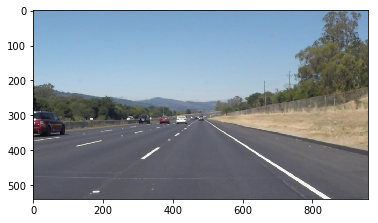

In [13]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    vertices = np.array([vertices], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    x, y = [], []
    
    if lines is None:
        return False
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            x += [x1, x2]
            y += [y1, y2]
            
    imshape = img.shape
    coef = np.polyfit(x=x, y=y, deg=1)            
    cv2.line(img, (int((imshape[0]-coef[1])/coef[0]), int(imshape[0])), (int((imshape[0]*0.6-coef[1])/coef[0]), \
                                                                         int(imshape[0]*0.6)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, thick):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if draw_lines(line_img, lines, thickness=thick) == False:
        plt.imshow(img)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Pipeline Function

In [ ]:
def process_image(image):
    # Convert to grayscale
    gray = grayscale(image)

    # Define a kernel size for Gaussian smoothing / blurring
    blur_gray = gaussian_blur(gray, kernel_size=7)

    # Define parameters for Canny and run it
    edges = canny(blur_gray, low_threshold=40, high_threshold=80)

    # Define the Hough transform parameters
    line_image = np.copy(image)*0 #creating a blank to draw lines on
    imshape = image.shape

    # Vertices = bottom_left, top, bottom_right
    left_vertices = [(0,imshape[0]), (imshape[1]/2, imshape[0]*0.55), (imshape[1]/2,imshape[0])]
    right_vertices = [(imshape[1]/2,imshape[0]), (imshape[1]/2, imshape[0]*0.55), (imshape[1],imshape[0])]

    # Create a left hand mask and right hand mask 
    left_canny = region_of_interest(img=edges, vertices=left_vertices)
    right_canny = region_of_interest(img=edges, vertices=right_vertices)

    # Run Hough on edge detected image
    left_hough = hough_lines(img=left_canny, rho=1, theta=np.pi/180, threshold=50, min_line_len=10, max_line_gap=30, thick=10)
    right_hough = hough_lines(img=right_canny, rho=1, theta=np.pi/180, threshold=50, min_line_len=10, max_line_gap=30, thick=10)

    # Combine the left and right segments
    final_hough = left_hough + right_hough

    # Draw the lines on the edge image
    combo = cv2.addWeighted(image, 0.8, final_hough, 1, 0) 

    # Display left section of the extracted canny image
    plt.imshow(left_canny)
    plt.figure()

    # Display right section of the extracted canny image
    plt.imshow(right_canny)
    plt.figure()
    
    # Display right section of the extracted canny image
    plt.imshow(left_hough)
    plt.figure()
    
    # Display right section of the extracted canny image
    plt.imshow(right_hough)
    plt.figure()

    # Display the annotated result
    plt.imshow(combo)
    
    return combo

## Testing pipeline on image

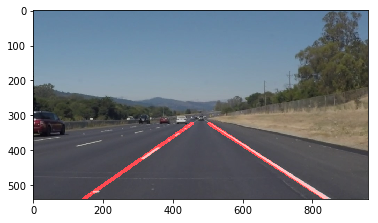

In [15]:
annotated = process_image(image)
plt.imshow(annotated)

## Testing on video

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile('white.mp4', audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 72.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 



In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Yellow lane lines

In [9]:
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile('yellow.mp4', audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:10<00:00, 67.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.1 s, sys: 4.36 s, total: 14.5 s
Wall time: 10.5 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

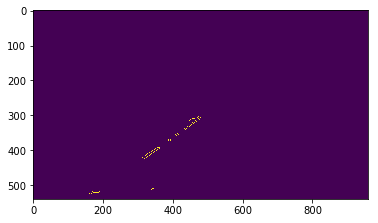

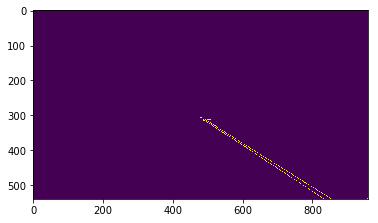

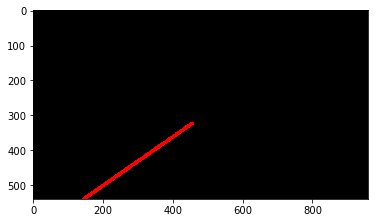

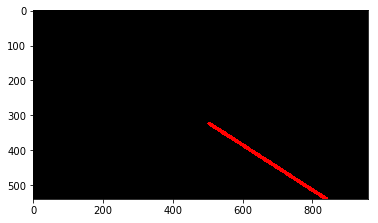

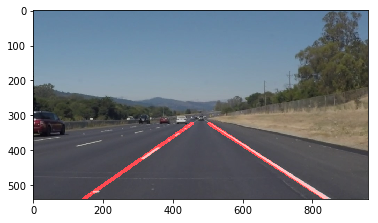

In [18]:
# Convert to grayscale
gray = grayscale(image)

# Define a kernel size for Gaussian smoothing / blurring
blur_gray = gaussian_blur(gray, kernel_size=7)

# Define parameters for Canny and run it
edges = canny(blur_gray, low_threshold=40, high_threshold=80)

# Define the Hough transform parameters
line_image = np.copy(image)*0 #creating a blank to draw lines on
imshape = image.shape

# Vertices = bottom_left, top, bottom_right
left_vertices = [(0,imshape[0]), (imshape[1]/2, imshape[0]*0.55), (imshape[1]/2,imshape[0])]
right_vertices = [(imshape[1]/2,imshape[0]), (imshape[1]/2, imshape[0]*0.55), (imshape[1],imshape[0])]

# Create a left hand mask and right hand mask 
left_canny = region_of_interest(img=edges, vertices=left_vertices)
right_canny = region_of_interest(img=edges, vertices=right_vertices)

# Run Hough on edge detected image
left_hough = hough_lines(img=left_canny, rho=1, theta=np.pi/180, threshold=50, min_line_len=10, max_line_gap=30, thick=10)
right_hough = hough_lines(img=right_canny, rho=1, theta=np.pi/180, threshold=50, min_line_len=10, max_line_gap=30, thick=10)

# Combine the left and right segments
final_hough = left_hough + right_hough

# Draw the lines on the edge image
combo = cv2.addWeighted(image, 0.8, final_hough, 1, 0) 

# Display left section of the extracted canny image
plt.imshow(left_canny)
cv2.imwrite('left_canny.jpg', left_canny)
plt.figure()

# Display right section of the extracted canny image
plt.imshow(right_canny)
cv2.imwrite('right_canny.jpg', right_canny)
plt.figure()

# Display right section of the extracted canny image
plt.imshow(left_hough)
cv2.imwrite('left_hough.jpg', left_hough)
plt.figure()

# Display right section of the extracted canny image
plt.imshow(right_hough)
cv2.imwrite('right_hough.jpg', right_hough)
plt.figure()

# Display the annotated result
plt.imshow(combo)